## input data
data can be the result of a simulation.
in this case we have spectra and corresponding redshift.

In [1]:
import astropy.io.fits as pyfits

#load the data
hdulist1 = pyfits.open('GALAXY_STARFORMING.fits')

header = hdulist1[1].header
# print(header.keys)
data = hdulist1[1].data


redshift = data['Z']
spectra = data['int_flux']

## Start SBI framework

In [2]:
# Import required libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sbi.inference import SNPE
from sbi.utils import BoxUniform

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Setup Prior and Inference Method 
### Define parameter ranges and initialize SBI framework

In [3]:
# Define the prior range for the parameters
redshift_range = (redshift.min(), redshift.max())

# Setup prior distribution
prior = BoxUniform(
    low=torch.tensor([redshift_range[0]]),  # inferior limit for redshift
    high=torch.tensor([redshift_range[1]])  # superior limit for redshift
)

# Inizialized the inference method
inference_method = SNPE(prior=prior)


### Generate Training and Validation Data

In [4]:
from sklearn.model_selection import train_test_split

# split the data into training and validation sets
spectra_train, spectra_test, redshift_train, redshift_test = train_test_split(
    spectra,     
    redshift,        
    test_size=0.2,  
    random_state=42,  
    shuffle=True  
)

# Convert the training and test redshift data to float32 and then to torch tensors
redshift_train = redshift_train.astype(np.float32)
redshift_train_torch = torch.from_numpy(redshift_train)
spectra_train = spectra_train.astype(np.float32)
spectra_train_torch = torch.from_numpy(spectra_train)

redshift_test = redshift_test.astype(np.float32)
redshift_test_torch = torch.from_numpy(redshift_test)
spectra_test = spectra_test.astype(np.float32)
spectra_test_torch = torch.from_numpy(spectra_test)

# Create tensors for the training and test data
redshift_train_tensor = torch.tensor(redshift_train_torch, dtype=torch.float32)
spectra_train_tensor = torch.tensor(spectra_train_torch, dtype=torch.float32)
spectra_test_tensor = torch.tensor(spectra_test_torch, dtype=torch.float32)
redshift_test_tensor = torch.tensor(redshift_test_torch, dtype=torch.float32)

/var/folders/6t/4h_bqrxj52qfg33z_48th4xc0000gn/T/ipykernel_44357/1256840857.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  redshift_train_tensor = torch.tensor(redshift_train_torch, dtype=torch.float32)
/var/folders/6t/4h_bqrxj52qfg33z_48th4xc0000gn/T/ipykernel_44357/1256840857.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  spectra_train_tensor = torch.tensor(spectra_train_torch, dtype=torch.float32)
/var/folders/6t/4h_bqrxj52qfg33z_48th4xc0000gn/T/ipykernel_44357/1256840857.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
 

### Train Neural Density Estimator

In [5]:
# Import a neural network model for posterior estimation
# one can choose between Masked Autoregressive Flow (MAF) and Neural Spline Flow (NSF)
# or mdn (Mixture Density Networks)

# documentation: https://sbi-dev.github.io/sbi/latest/reference/models/#sbi.neural_nets.factory.posterior_nn

from sbi.utils.get_nn_models import posterior_nn

# Costruzione di un Masked Autoregressive Flow (MAF) personalizzato
# Construction of a custom Masked Autoregressive Flow (MAF)
density_estimator = posterior_nn(
    model='maf',                    # Use a 'maf' (Masked Autoregressive Flow) (other options: 'nsf', 'mdn')
    hidden_features=64,            # number of hidden nodes per layer
    num_transforms=5,               # number of layers of the flow
    activation_function="relu",     # Use ReLU as activation
    dropout_probability=0,        # Apply a 10% dropout
    use_batch_norm=False             # Use batch normalization
)

# training
inference_method = SNPE(prior=prior, density_estimator=density_estimator)
density_estimator = inference_method.append_simulations(redshift_train_tensor, spectra_train_tensor
).train(
    validation_fraction=0.2,
    max_num_epochs=500,  
    stop_after_epochs=20,  
    learning_rate=1e-3,   
    training_batch_size=256       
)


# Build posterior distribution
posterior = inference_method.build_posterior(density_estimator)

/var/folders/6t/4h_bqrxj52qfg33z_48th4xc0000gn/T/ipykernel_44357/1714179338.py:11: DeprecationWarning: This method is deprecated and will be removed in a future release.Please use `from sbi.neural_nets import posterior_nn` in the future.
  density_estimator = posterior_nn(
/opt/anaconda3/envs/sbi_env/lib/python3.9/site-packages/sbi/neural_nets/net_builders/flow.py:141: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  x_numel = get_numel(


 Neural network successfully converged after 43 epochs.

### Perform Inference on a Single Test Case

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]


Single Test Case Results:
--------------------------
True Redshift: 0.093
Posterior Mean: 0.091
Posterior Std: 0.003


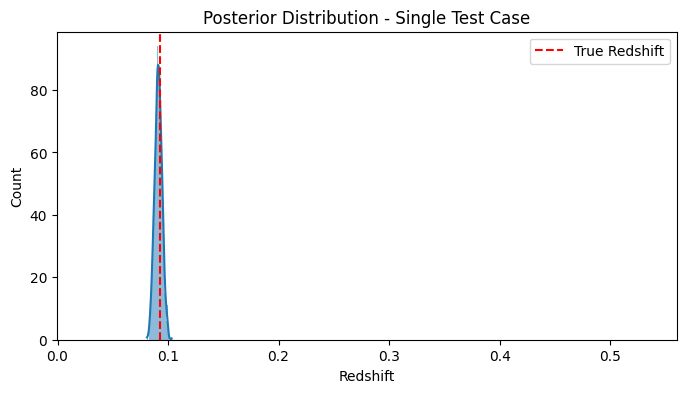

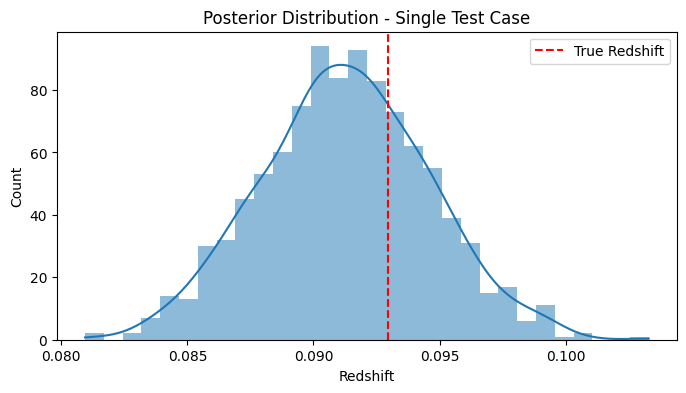

In [8]:
# Select a random spectrum from the validation set for the single test
random_idx = np.random.randint(0, len(spectra_test_tensor))
observed_spectrum = spectra_test_tensor[random_idx]
true_redshift = redshift_test_tensor[random_idx].item()  # Convert to float for printing

# Perform inference (sample from the posterior for the observed spectrum)
n_samples = 1000
# If necessary, ensure that observed_spectrum is 2D
if observed_spectrum.dim() == 1:
    observed_spectrum = observed_spectrum.unsqueeze(0)  # Add a dimension if required

posterior_samples = posterior.sample((n_samples,), x=observed_spectrum)

# Display the results
posterior_mean = posterior_samples.mean().item()
posterior_std = posterior_samples.std().item()

print(f"\nSingle Test Case Results:")
print("--------------------------")
print(f"True Redshift: {true_redshift:.3f}")
print(f"Posterior Mean: {posterior_mean:.3f}")
print(f"Posterior Std: {posterior_std:.3f}")

"""
Visualize Posterior Distribution for Single Test
"""
# Visualize the posterior distribution for the single test
# full range of redshift
plt.figure(figsize=(8, 4))
sns.histplot(posterior_samples.numpy(), kde=True, bins=30, edgecolor=None)
plt.axvline(true_redshift, color='red', linestyle='--', label='True Redshift')
plt.xlabel('Redshift')
plt.title('Posterior Distribution - Single Test Case')
plt.legend()
plt.xlim(redshift.min(), redshift.max())
plt.show()

# Visualize the posterior distribution for the single test
# zoom in on the range of redshift
plt.figure(figsize=(8, 4))
sns.histplot(posterior_samples.numpy(), kde=True, bins=30, edgecolor=None)
plt.axvline(true_redshift, color='red', linestyle='--', label='True Redshift')
plt.xlabel('Redshift')
plt.title('Posterior Distribution - Single Test Case')
plt.legend()


In [ ]:
redshift.max()

### Global Test Set Evaluation

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

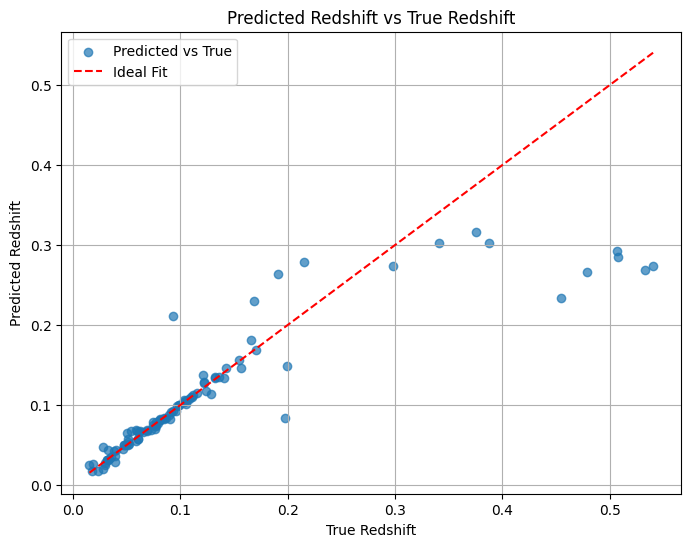


Global Test Set Performance:
Mean Absolute Error (MAE): 0.093


In [9]:
posterior_means = []
posterior_stds = []
predicted_redshifts = []

# Perform inference for 100 examples of the test set
for i in range(min(100, len(spectra_test))):
    # Perform inference (sample from the posterior for the observed spectrum)
    posterior_samples_test = posterior.sample((n_samples,), x=spectra_test[i])
    
    # get the mean of the posterior samples
    pdf_mean = posterior_samples_test.mean().item()  
    
    # Appendi i risultati
    posterior_means.append(posterior_samples_test.mean().item())
    posterior_stds.append(posterior_samples_test.std().item())
    predicted_redshifts.append(pdf_mean)

# Convert the lists to numpy arrays
predicted_redshifts = np.array(predicted_redshifts)
true_redshifts = redshift_test[:len(predicted_redshifts)]  

# visualize the predicted redshifts vs the true redshifts
plt.figure(figsize=(8, 6))
plt.scatter(true_redshifts, predicted_redshifts, alpha=0.7, label='Predicted vs True')
plt.plot([true_redshifts.min(), true_redshifts.max()], [true_redshifts.min(), true_redshifts.max()], 'r--', label='Ideal Fit')
plt.xlabel('True Redshift')
plt.ylabel('Predicted Redshift')
plt.title('Predicted Redshift vs True Redshift')
plt.legend()
plt.grid(True)
plt.show()

# print the global test set performance
absolute_errors = np.abs(predicted_redshifts - true_redshifts)
mae = np.mean(absolute_errors)
print(f"\nGlobal Test Set Performance:")
print(f"Mean Absolute Error (MAE): {mae:.3f}")


In [11]:
pip show torch

Name: torch
Version: 2.2.2
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: /opt/anaconda3/envs/sbi_env/lib/python3.9/site-packages
Requires: filelock, fsspec, jinja2, networkx, sympy, typing-extensions
Required-by: nflows, pyknos, pyro-ppl, sbi, zuko
Note: you may need to restart the kernel to use updated packages.
